# Image classification

## Import TensorFlow and other libraries

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Download and explore the dataset

In [166]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [167]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists
'4 - Data figures.ipynb'	 erasmus       Recognition.ipynb
'Colab Notebooks'		 IBB_Assign2   yolov4
 CollectiveBehaviour		'My Drive'     Yolov4TrainDetector.ipynb
'Collective behaviour.gslides'	 Recognition


In [168]:
!unzip gdrive/MyDrive/Recognition/ear_detection_predictions.zip

Archive:  gdrive/MyDrive/Recognition/ear_detection_predictions.zip
replace ear_detection_predictions/annotations/recognition/ids.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ear_detection_predictions/annotations/recognition/ids.csv  
 extracting: ear_detection_predictions/test/0001.png  
 extracting: ear_detection_predictions/test/0002.png  
 extracting: ear_detection_predictions/test/0003.png  
 extracting: ear_detection_predictions/test/0004.png  
 extracting: ear_detection_predictions/test/0005.png  
 extracting: ear_detection_predictions/test/0006.png  
 extracting: ear_detection_predictions/test/0007.png  
  inflating: ear_detection_predictions/test/0008.png  
 extracting: ear_detection_predictions/test/0009.png  
 extracting: ear_detection_predictions/test/0010.png  
 extracting: ear_detection_predictions/test/0011.png  
  inflating: ear_detection_predictions/test/0012.png  
 extracting: ear_detection_predictions/test/0013.png  
 extracting: ear_detection_predictions

In [169]:
root_path = 'ear_detection_predictions/'
train_path = root_path+'train/'
test_path = root_path + 'test/'
annotations_id = root_path + 'annotations/recognition//ids.csv'

In [170]:
def get_annotations(annot_f):
  d = {}
  with open(annot_f) as f:
      lines = f.readlines()
      for line in lines:
          (key, val) = line.split(',')
          # keynum = int(self.clean_file_name(key))
          d[key] = int(val)
  return d

In [ ]:
import glob
import shutil
cla_d = get_annotations(annotations_id)

im_list = sorted(glob.glob(train_path + '*.png', recursive=True))
im_list_test = sorted(glob.glob(test_path + '*.png', recursive=True))
y=[]

for im_name in im_list:
  y.append(cla_d['/'.join(im_name.split('/')[-2:])])

classes = np.unique(sorted(y))
for img_class in classes:
  os.mkdir(train_path+str(img_class))
  os.mkdir(test_path+str(img_class))

for im_name in im_list:
  name_img = im_name.split('/')[-1:]
  x = '/'.join(im_name.split('/')[-2:])
  shutil.move(train_path+name_img[0], train_path+str(cla_d[x])+"/"+name_img[0])


for im_name in im_list_test:
  name_img = im_name.split('/')[-1:]
  x = '/'.join(im_name.split('/')[-2:])
  shutil.move(test_path+name_img[0], test_path+str(cla_d[x])+"/"+name_img[0])

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

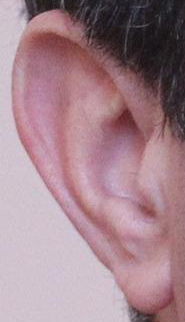

In [173]:
#data_dir = tf.keras.utils.get_file('train images', origin=train_path, untar=True)
import pathlib
train_data_dir = pathlib.Path(train_path)
ear_1 = list(train_data_dir.glob('1/*'))
PIL.Image.open(str(ear_1[0]))

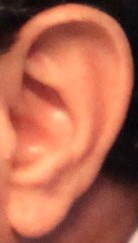

In [174]:
PIL.Image.open(str(ear_1[1]))

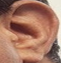

In [175]:
test_data_dir = pathlib.Path(test_path)
ear_1 = list(test_data_dir.glob('1/*'))
PIL.Image.open(str(ear_1[0]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [176]:
batch_size = 32
img_height = 64 #224 #180
img_width = 64 #224 #180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [177]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 750 files belonging to 100 classes.
Using 600 files for training.


In [178]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 750 files belonging to 100 classes.
Using 150 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [179]:
class_names = train_ds.class_names
print(len(class_names))

100


## Visualize the data

Here are the first nine images from the training dataset:

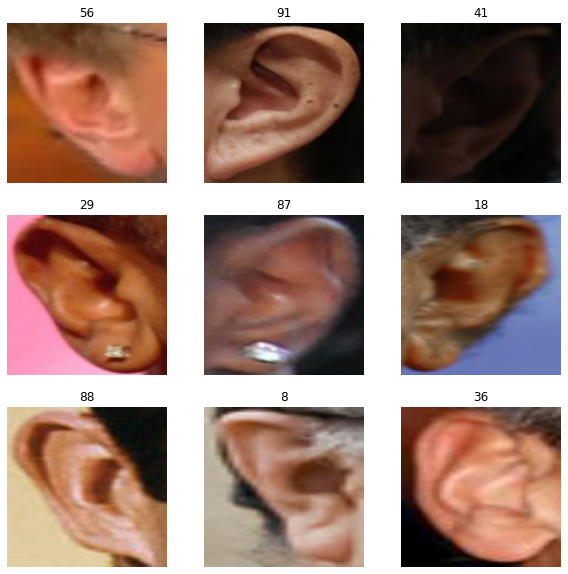

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [113]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [180]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [181]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [196]:
train_normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.8018897


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model (Resnet50)

In [251]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [252]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [253]:
def ResNet50(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [254]:
model = ResNet50(input_shape = (img_height, img_width, 3), classes = len(class_names))

In [255]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [256]:
epochs = 25
history = model.fit(train_normalized_ds, validation_data = val_normalized_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 7s 107ms/step - loss: 7.2841 - accuracy: 0.0017 - val_loss: 4.7198 - val_accuracy: 0.0133
Epoch 2/25
19/19 [==============================] - 1s 63ms/step - loss: 6.2675 - accuracy: 0.0233 - val_loss: 4.7018 - val_accuracy: 0.0000e+00
Epoch 3/25
19/19 [==============================] - 1s 60ms/step - loss: 5.6408 - accuracy: 0.0350 - val_loss: 4.7338 - val_accuracy: 0.0067
Epoch 4/25
19/19 [==============================] - 1s 60ms/step - loss: 5.1154 - accuracy: 0.0500 - val_loss: 4.8359 - val_accuracy: 0.0000e+00
Epoch 5/25
19/19 [==============================] - 1s 61ms/step - loss: 5.4726 - accuracy: 0.0400 - val_loss: 5.0005 - val_accuracy: 0.0000e+00
Epoch 6/25
19/19 [==============================] - 1s 60ms/step - loss: 4.2740 - accuracy: 0.1550 - val_loss: 5.0349 - val_accuracy: 0.0000e+00
Epoch 7/25
19/19 [==============================] - 1s 60ms/step - loss: 4.7800 - accuracy: 0.1350 - val_loss: 5.2515 - val_accuracy: 0.0133
Epoch 8

# Create the model (Sequential)

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [148]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [149]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [150]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 64)       

## Train the model

In [151]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
19/19 [==============================] - 2s 57ms/step - loss: 4.8088 - accuracy: 0.0100 - val_loss: 4.6189 - val_accuracy: 0.0067
Epoch 2/10
19/19 [==============================] - 1s 29ms/step - loss: 4.5989 - accuracy: 0.0167 - val_loss: 4.6128 - val_accuracy: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 1s 29ms/step - loss: 4.5427 - accuracy: 0.0133 - val_loss: 4.6718 - val_accuracy: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 1s 28ms/step - loss: 4.4306 - accuracy: 0.0483 - val_loss: 4.6903 - val_accuracy: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 1s 28ms/step - loss: 4.1780 - accuracy: 0.0867 - val_loss: 4.8819 - val_accuracy: 0.0067
Epoch 6/10
19/19 [==============================] - 1s 28ms/step - loss: 3.7518 - accuracy: 0.1950 - val_loss: 4.9831 - val_accuracy: 0.0200
Epoch 7/10
19/19 [==============================] - 1s 29ms/step - loss: 3.0163 - accuracy: 0.3167 - val_loss: 5.2184 - val_accuracy: 0.0467
E

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

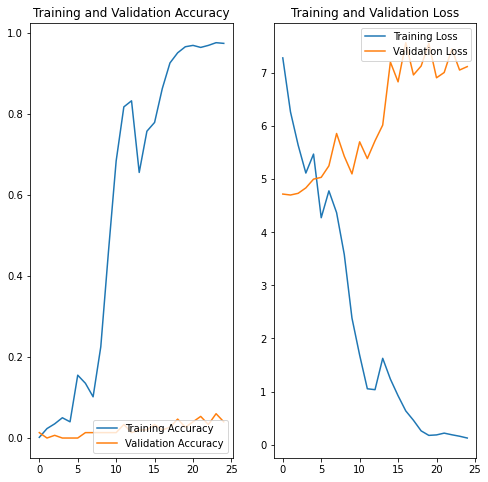

In [257]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [267]:
# métricas de perda e acurácia
score = model.evaluate_generator(val_normalized_ds, 105)

print ("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


loss: 711.99%
accuracy: 4.00%


The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

### For Sequential

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [212]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

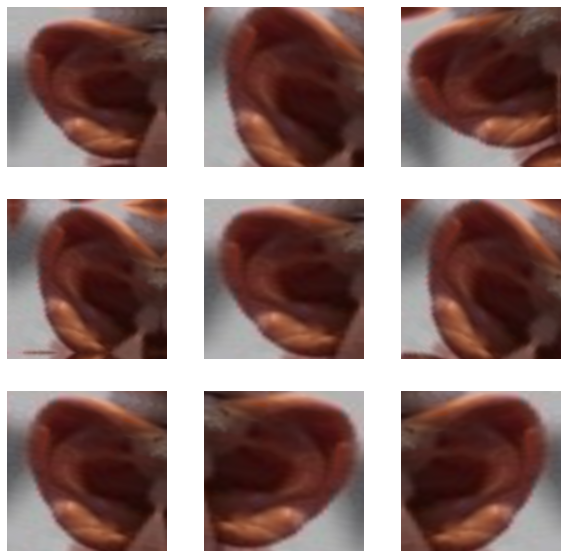

In [94]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [95]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [98]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
19/19 [==============================] - 1s 34ms/step - loss: 4.6277 - accuracy: 0.0050 - val_loss: 4.6065 - val_accuracy: 0.0200
Epoch 2/15
19/19 [==============================] - 0s 24ms/step - loss: 4.6043 - accuracy: 0.0167 - val_loss: 4.6381 - val_accuracy: 0.0067
Epoch 3/15
19/19 [==============================] - 0s 24ms/step - loss: 4.5906 - accuracy: 0.0117 - val_loss: 4.6279 - val_accuracy: 0.0067
Epoch 4/15
19/19 [==============================] - 0s 24ms/step - loss: 4.5505 - accuracy: 0.0300 - val_loss: 4.6064 - val_accuracy: 0.0333
Epoch 5/15
19/19 [==============================] - 0s 24ms/step - loss: 4.4995 - accuracy: 0.0250 - val_loss: 4.7021 - val_accuracy: 0.0067
Epoch 6/15
19/19 [==============================] - 0s 23ms/step - loss: 4.4048 - accuracy: 0.0417 - val_loss: 4.6585 - val_accuracy: 0.0333
Epoch 7/15
19/19 [==============================] - 0s 24ms/step - loss: 4.2828 - accuracy: 0.0567 - val_loss: 4.7349 - val_accuracy: 0.0333
Epoch 8/15
19

### For Resnet50

In [214]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode = "nearest"
)

In [215]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode = "nearest", 
    vertical_flip=True,
)

In [241]:
import numpy
name_imgs = []
for im_name in im_list:
  name_imgs.append(im_name.split('/')[-1:][0])
arr = numpy.array(name_imgs)
print(y)

[100, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 2, 14, 15, 15, 15, 15, 15, 15, 2, 15, 16, 16, 16, 16, 16, 16, 2, 16, 17, 17, 17, 17, 17, 17, 2, 17, 18, 18, 18, 18, 18, 18, 18, 2, 19, 19, 19, 19, 19, 19, 19, 19, 19, 2, 20, 20, 20, 20, 20, 20, 20, 2, 20, 21, 21, 21, 21, 21, 21, 2, 21, 22, 22, 22, 22, 22, 22, 3, 22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 3, 26, 27, 27, 27, 27, 27, 27, 3, 27, 28, 28, 28, 28, 28, 28, 3, 28, 29, 29, 29, 29, 29, 29, 3, 29, 30, 30, 30, 30, 30, 30, 30, 3, 1, 31, 31, 31, 31, 31, 31, 31, 31, 31, 3, 32, 32, 32, 32, 32, 32, 32, 4, 32, 33, 33, 33, 33, 33, 33, 4, 33, 34, 34, 34, 34, 34, 34, 4, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 4, 38, 39, 39, 39, 39, 39, 39, 4, 39, 40, 40, 40, 40, 40, 40, 4, 1, 40, 41, 41, 41, 41, 41, 4

In [ ]:
history = model.fit(train_datagen.flow(arr, y, batch_size=64),validation_data=val_ds, epochs= 100)

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

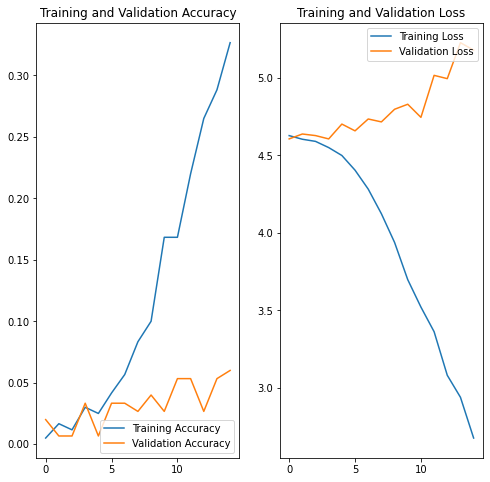

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

Input image shape: (1, 64, 64, 3)
[60]


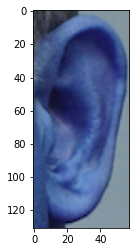

In [276]:
import cv2

img_path = test_path + '0005.png'
img = image.load_img(img_path, target_size=(img_height, img_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = cv2.imread(img_path)
imshow(my_image)
print(np.argmax(model.predict(x), axis=-1))

In [277]:
y_preds = []
for img in im_list_test:
  name_img = img.split('/')[-1:][0]
  img_path = test_path + name_img
  img = image.load_img(img_path, target_size=(img_height, img_width))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  result = np.argmax(model.predict(x), axis=-1)
  y_preds.append(result)

In [ ]:
import seaborn as sns

y_true = []
for im_name in im_list_test:
  y_true.append(cla_d['/'.join(im_name.split('/')[-2:])])

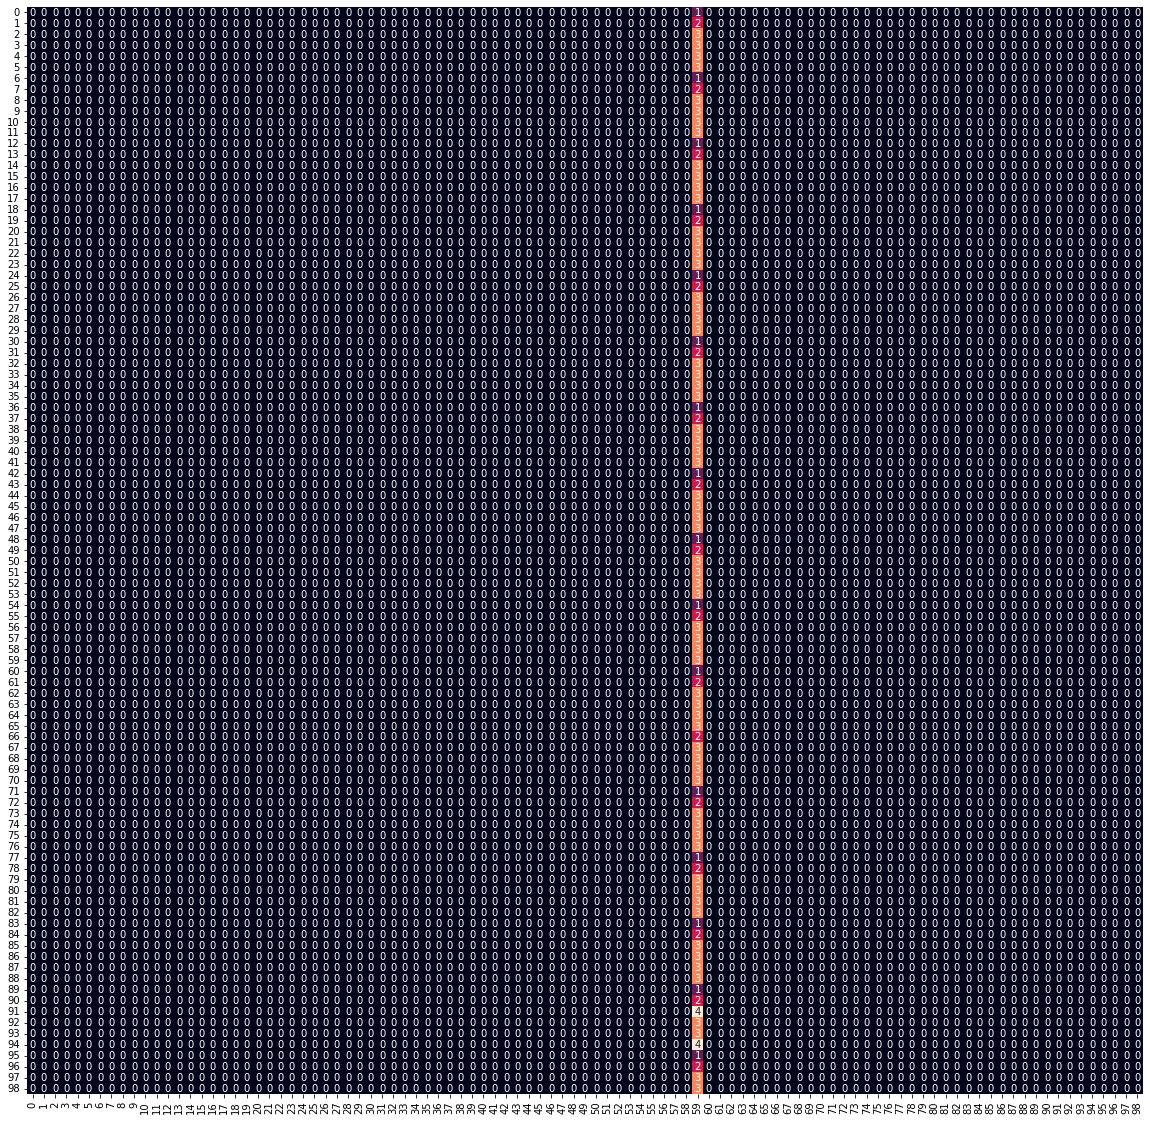

In [281]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize = (20, 20))
sns.heatmap(cm, annot = True, cbar = False)